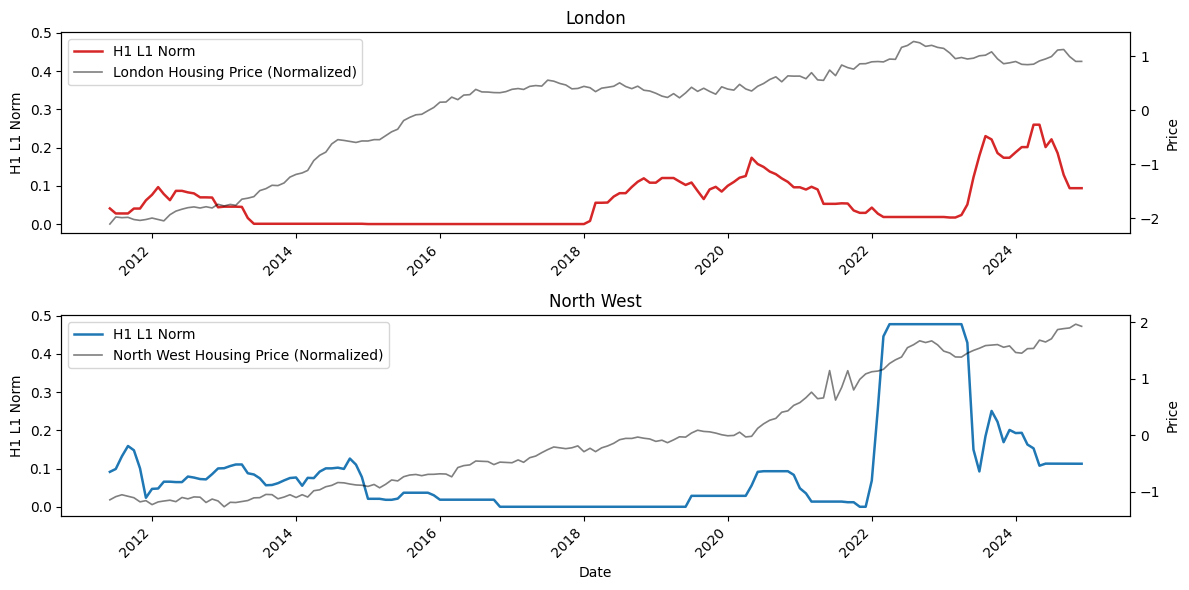

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
import gudhi as gd
import matplotlib.dates as mdates

# Params
lag_dim = 5
window_size = 24
max_edge_length = 50.0
target_col = "Average_Housing_Price"


#  H1 L1 over time (London)

def compute_h1_l1_series(series, date_array=None, lag_dim=5, window_size=24,
                         max_edge_length=50.0):
    series = np.asarray(series).flatten()
    embed_dim = lag_dim + 1
    lagged = sliding_window_view(series, window_shape=embed_dim)

    if date_array is None:
        date_array = np.arange(len(series))
    else:
        date_array = np.asarray(date_array)[embed_dim - 1:]

    def h1_l1_of_cloud(cloud_slice):
        rips = gd.RipsComplex(points=cloud_slice, max_edge_length=max_edge_length)
        st = rips.create_simplex_tree(max_dimension=2)
        persistence = st.persistence()
        return sum(d - b for dim, (b, d) in persistence if dim == 1 and np.isfinite(d))

    vals, dates = [], []
    for i in range(len(lagged) - window_size):
        cloud = lagged[i:i + window_size]
        vals.append(h1_l1_of_cloud(cloud))
        dates.append(date_array[i + window_size])
    return pd.to_datetime(dates), np.array(vals)


nw = pd.read_csv("North_West_Housing_Policy_Dataset_sd.csv", parse_dates=["Date"]).sort_values("Date")
ld = pd.read_csv("London_Housing_Policy_Dataset_sd.csv", parse_dates=["Date"]).sort_values("Date")

# Compute L1 series
nw_dates, nw_l1 = compute_h1_l1_series(nw[target_col].values, nw["Date"].values,
                                       lag_dim=lag_dim, window_size=window_size,
                                       max_edge_length=max_edge_length)
ld_dates, ld_l1 = compute_h1_l1_series(ld[target_col].values, ld["Date"].values,
                                       lag_dim=lag_dim, window_size=window_size,
                                       max_edge_length=max_edge_length)

# Align to common start
common_start = max(nw_dates.min(), ld_dates.min())
nw_mask = nw_dates >= common_start
ld_mask = ld_dates >= common_start
nw_dates, nw_l1 = nw_dates[nw_mask], nw_l1[nw_mask]
ld_dates, ld_l1 = ld_dates[ld_mask], ld_l1[ld_mask]

# Also trim original price series for plotting
nw_price = nw[nw["Date"] >= common_start].copy()
ld_price = ld[ld["Date"] >= common_start].copy()

# Normalize price for overlay
nw_price_norm = (nw_price[target_col] - nw_price[target_col].mean()) / nw_price[target_col].std()
ld_price_norm = (ld_price[target_col] - ld_price[target_col].mean()) / ld_price[target_col].std()

y_min = min(nw_l1.min(), ld_l1.min())
y_max = max(nw_l1.max(), ld_l1.max())
pad = 0.05 * (y_max - y_min if y_max > y_min else 1.0)
y_limits = (y_min - pad, y_max + pad)


fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=False)
(ax_ld, ax_nw) = axes

# --- London plot ---
ln1 = ax_ld.plot(ld_dates, ld_l1, lw=1.8, color="tab:red", label="H1 L1 Norm")[0]
ax_ld.set_ylabel("H1 L1 Norm")
ax_ld.set_ylim(y_limits)
ax_ld.set_title(f"London")
ax_ld.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for t in ax_ld.get_xticklabels():
    t.set_rotation(45); t.set_ha('right')

ax_ld_2 = ax_ld.twinx()
ln2 = ax_ld_2.plot(ld_price["Date"], ld_price_norm, lw=1.2, color="black", alpha=0.5, label="London Housing Price (Normalized)")[0]
ax_ld_2.set_ylabel("Price", color="black")
ax_ld_2.tick_params(axis='y', labelcolor='black')

# Combine legends
lines_ld = [ln1, ln2]
labels_ld = [line.get_label() for line in lines_ld]
ax_ld.legend(lines_ld, labels_ld, loc="upper left")

# --- North West plot ---
ln3 = ax_nw.plot(nw_dates, nw_l1, lw=1.8, color="tab:blue", label="H1 L1 Norm")[0]
ax_nw.set_ylabel("H1 L1 Norm")
ax_nw.set_title(f"North West")
ax_nw.set_xlabel("Date")
ax_nw.set_ylim(y_limits)
ax_nw.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
for t in ax_nw.get_xticklabels():
    t.set_rotation(45); t.set_ha('right')

ax_nw_2 = ax_nw.twinx()
ln4 = ax_nw_2.plot(nw_price["Date"], nw_price_norm, lw=1.2, color="black", alpha=0.5, label="North West Housing Price (Normalized)")[0]
ax_nw_2.set_ylabel("Price", color="black")
ax_nw_2.tick_params(axis='y', labelcolor='black')

# Combine legends
lines_nw = [ln3, ln4]
labels_nw = [line.get_label() for line in lines_nw]
ax_nw.legend(lines_nw, labels_nw, loc="upper left")

# Figure 4.1 Univariate L₁ norm and prices for London and Northwest housing prices 
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
df = pd.DataFrame({
    "LD_L1": ld_l1,
    "NW_L1": nw_l1
})

df.to_csv("norm0-LD-NW.csv", index=False)


In [3]:
# Pair T-test
import pandas as pd
from scipy.stats import ttest_rel

df = pd.read_csv("norm0-LD-NW.csv")

ld_values = df["LD_L1"]
nw_values = df["NW_L1"]

t_stat, p_val = ttest_rel(ld_values, nw_values)

print(f"t-value: {t_stat:.4f}")
print(f"p-value: {p_val:.5f}")

t-value: -3.2966
p-value: 0.00120


In [4]:
# Descriptive Statistics
nw_l1_series = pd.Series(nw_l1, index=nw_dates)
ld_l1_series = pd.Series(ld_l1, index=ld_dates)

print(ld_l1_series.describe())
print(nw_l1_series.describe())
#Table 4.1 Descriptive statistics of the L₁ norm of the univariate embedding point cloud

count    163.000000
mean       0.058314
std        0.063982
min        0.000000
25%        0.000703
50%        0.040815
75%        0.096431
max        0.259952
dtype: float64
count    163.000000
mean       0.096013
std        0.132024
min        0.000000
25%        0.013555
50%        0.056282
75%        0.107027
max        0.477736
dtype: float64


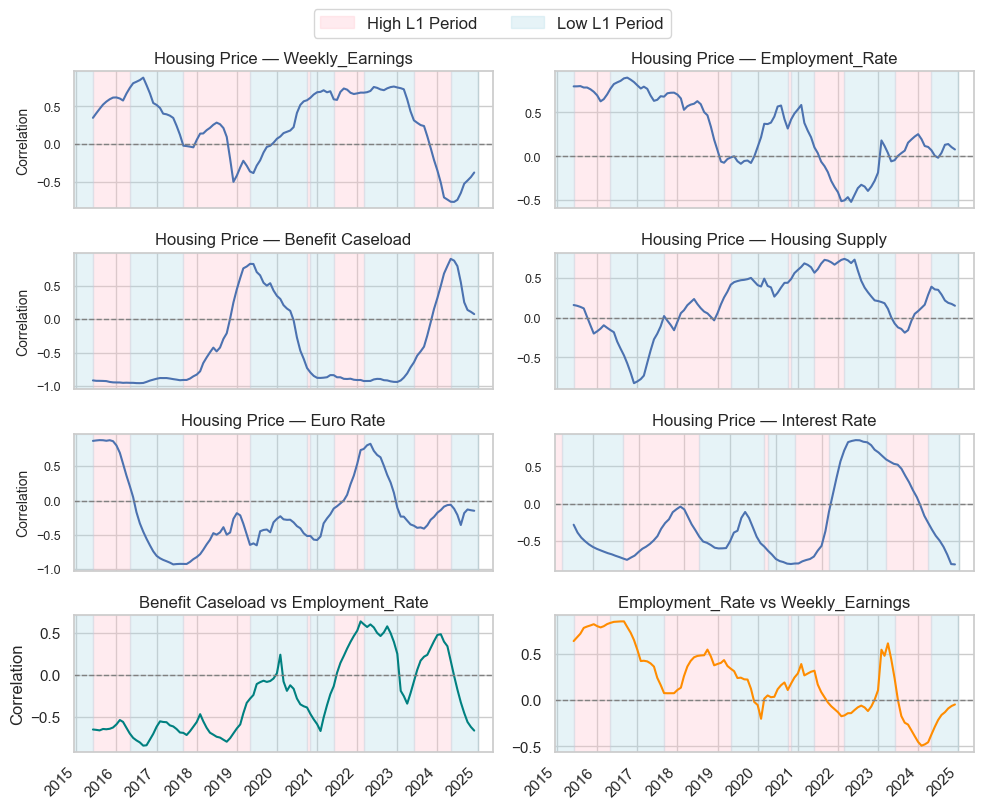

In [6]:
# Figure 4.4  Rolling correlation between policy variables and house prices (London, 2015–2024)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.patches import Patch


df = pd.read_csv("London_Housing_Policy_Dataset_sd.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

target_col = "Average_Housing_Price"
policy_vars = [col for col in df.columns if col not in ['Date', target_col]]

sns.set(style="whitegrid")

# high/low norm periods（London）
high_periods_filtered = [
    ("2012-03-01", "2012-06-30"),
    ("2012-11-01", "2014-03-31"),
    ("2014-06-01", "2014-07-31"),
    ("2015-06-01", "2016-04-30"),
    ("2017-09-01", "2019-04-30"),
    ("2020-10-01", "2020-10-31"),
    ("2021-06-01", "2022-02-28"),
    ("2023-06-01", "2024-04-30")
]
low_periods_filtered = [
    ("2011-07-01", "2012-02-29"),
    ("2012-07-01", "2012-10-31"),
    ("2014-04-01", "2014-05-31"),
    ("2014-08-01", "2015-05-31"),
    ("2016-05-01", "2017-08-31"),
    ("2019-05-01", "2020-09-30"),
    ("2020-11-01", "2021-05-31"),
    ("2022-03-01", "2023-05-31"),
    ("2024-05-01", "2024-12-31")
]

# === 4*2Subplots ===
fig, axes = plt.subplots(4, 2, figsize=(10, 8))
axes = axes.flatten()


legend_elements = [
    Patch(facecolor='pink', edgecolor='pink', alpha=0.3, label='High L1 Period'),
    Patch(facecolor='lightblue', edgecolor='lightblue', alpha=0.3, label='Low L1 Period')
]

# === 1-6：Policies v.s. Housing price ===
for i, var in enumerate(policy_vars[:6]):
    ax = axes[i]
    window = 30 if var == "Interest Rate" else 24

    corrs = df[[target_col, var]].rolling(window=window).corr().unstack().iloc[:, 1]
    rolling_corr_df = pd.DataFrame({
        "Date": df["Date"],
        "Correlation": corrs
    })
    rolling_corr_df = rolling_corr_df[rolling_corr_df["Date"] >= "2015-06-01"]

    ax.plot(rolling_corr_df["Date"], rolling_corr_df["Correlation"],
            label=f"{var} (Window={window})", linewidth=1.5)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    for start, end in high_periods_filtered:
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='pink', alpha=0.3)
    for start, end in low_periods_filtered:
        ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='lightblue', alpha=0.3)

    ax.set_title(f"Housing Price — {var}", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    if i % 2 != 0:
        ax.set_ylabel('')
    if i < 6:
        ax.set_xlabel('')
        ax.tick_params(labelbottom=False)
    if i % 2 == 0:
        ax.set_ylabel("Correlation", fontsize=10)

# 7：Benefit Caseload vs Employment Rate
pair_1 = ("Benefit Caseload", "Employment_Rate")
window_1 = 24
corrs_1 = df[list(pair_1)].rolling(window=window_1).corr().unstack().iloc[:, 1]
rolling_corr_df1 = pd.DataFrame({"Date": df["Date"], "Correlation": corrs_1})
rolling_corr_df1 = rolling_corr_df1[rolling_corr_df1["Date"] >= "2015-06-01"]

ax = axes[6]
ax.plot(rolling_corr_df1["Date"], rolling_corr_df1["Correlation"],
        label=f"{pair_1[0]} vs {pair_1[1]} (Window={window_1})", color='teal')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
for start, end in high_periods_filtered:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='pink', alpha=0.3)
for start, end in low_periods_filtered:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='lightblue', alpha=0.3)
ax.set_title(f"{pair_1[0]} vs {pair_1[1]}")
ax.set_ylabel("Correlation")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

#  8：Employment Rate vs Weekly Earnings
pair_2 = ("Employment_Rate", "Weekly_Earnings")
window_2 = 24
corrs_2 = df[list(pair_2)].rolling(window=window_2).corr().unstack().iloc[:, 1]
rolling_corr_df2 = pd.DataFrame({"Date": df["Date"], "Correlation": corrs_2})
rolling_corr_df2 = rolling_corr_df2[rolling_corr_df2["Date"] >= "2015-06-01"]

ax = axes[7]
ax.plot(rolling_corr_df2["Date"], rolling_corr_df2["Correlation"],
        label=f"{pair_2[0]} vs {pair_2[1]} (Window={window_2})", color='darkorange')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
for start, end in high_periods_filtered:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='pink', alpha=0.3)
for start, end in low_periods_filtered:
    ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='lightblue', alpha=0.3)
ax.set_title(f"{pair_2[0]} vs {pair_2[1]}")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()



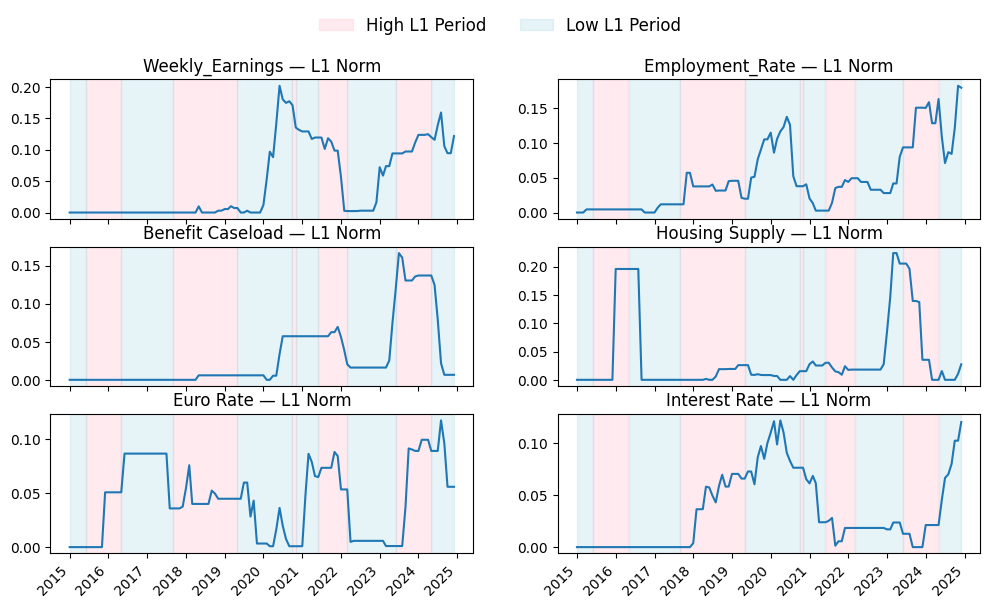

In [5]:
# Figure 4.6 The L₁ norm of the bivariate embedding point cloud (London) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches


df = pd.read_csv("London_Housing_Policy_Dataset_sd.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

policy_variables = [
    'Weekly_Earnings', 'Employment_Rate',
    'Benefit Caseload', 'Housing Supply',
    'Euro Rate', 'Interest Rate'
]
lag_dim = 5
window_size = 24
max_edge_length = 10.0

# high/low norm periods（London）
high_periods_filtered = [
    ("2012-03-01", "2012-06-30"),
    ("2012-11-01", "2014-03-31"),
    ("2014-06-01", "2014-07-31"),
    ("2015-06-01", "2016-04-30"),
    ("2017-09-01", "2019-04-30"),
    ("2020-10-01", "2020-10-31"),
    ("2021-06-01", "2022-02-28"),
    ("2023-06-01", "2024-04-30")
]

low_periods_filtered = [
    ("2011-07-01", "2012-02-29"),
    ("2012-07-01", "2012-10-31"),
    ("2014-04-01", "2014-05-31"),
    ("2014-08-01", "2015-05-31"),
    ("2016-05-01", "2017-08-31"),
    ("2019-05-01", "2020-09-30"),
    ("2020-11-01", "2021-05-31"),
    ("2022-03-01", "2023-05-31"),
    ("2024-05-01", "2024-12-31")
]


scaler = StandardScaler()
numeric_cols = ['Average_Housing_Price'] + policy_variables
df_std = df.copy()
df_std[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# H1 L1
def compute_h1_l1(cloud_slice, max_edge_length_local):
    if cloud_slice.shape[0] < 2:
        return 0.0
    rips = gd.RipsComplex(points=cloud_slice, max_edge_length=max_edge_length_local)
    st = rips.create_simplex_tree(max_dimension=2)
    persistence = st.persistence()
    return sum(death - birth for dim, (birth, death) in persistence
               if dim == 1 and np.isfinite(death))

# plot (only show after 2015-01) 
fig, axes = plt.subplots(3, 2, figsize=(12, 6))  # 不用 constrained_layout，避免与 subplots_adjust 冲突
axes = axes.flatten()

for idx, policy_var in enumerate(policy_variables):
    ax = axes[idx]

    #lagged
    h_series = df_std['Average_Housing_Price'].values
    p_series = df_std[policy_var].values
    lagged_h = sliding_window_view(h_series, window_shape=lag_dim + 1)
    aligned_p = p_series[lag_dim:].reshape(-1, 1)
    num_points = min(len(lagged_h), len(aligned_p))
    combined_points = np.c_[lagged_h[:num_points], aligned_p[:num_points]]

    # Sliding window
    h1_l1_series = []
    window_end_indices = []
    for i in range(len(combined_points) - window_size + 1):
        subcloud = combined_points[i: i + window_size]
        h1_l1_series.append(compute_h1_l1(subcloud, max_edge_length_local=max_edge_length))
        window_end_indices.append(lag_dim + i + window_size - 1)

    # AlignDate（），IntervalFilter
    dates_all = df.loc[window_end_indices, "Date"].values
    h1_all = np.array(h1_l1_series)

    mask = dates_all >= np.datetime64("2015-01-01")
    dates = dates_all[mask]
    h1_vals = h1_all[mask]

    # Shading（Interval）
    disp_start = pd.to_datetime("2015-01-01")
    disp_end = pd.to_datetime(dates[-1]) if len(dates) else pd.to_datetime("2015-01-01")

    for start, end in high_periods_filtered:
        s, e = pd.to_datetime(start), pd.to_datetime(end)
        s_clip, e_clip = max(s, disp_start), min(e, disp_end)
        if s_clip < e_clip:
            ax.axvspan(s_clip, e_clip, color='pink', alpha=0.3, zorder=1)

    for start, end in low_periods_filtered:
        s, e = pd.to_datetime(start), pd.to_datetime(end)
        s_clip, e_clip = max(s, disp_start), min(e, disp_end)
        if s_clip < e_clip:
            ax.axvspan(s_clip, e_clip, color='lightblue', alpha=0.3, zorder=1)

    #  Plot L1
    ax.plot(dates, h1_vals, color='tab:blue', linewidth=1.5, zorder=2)

    ax.set_title(f"{policy_var} — L1 Norm", fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


    if idx < 4:
        ax.tick_params(labelbottom=False)
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')

for j in range(len(policy_variables), len(axes)):
    fig.delaxes(axes[j])

high_patch = mpatches.Patch(color='pink', alpha=0.3, label='High L1 Period')
low_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Low L1 Period')
fig.legend(handles=[high_patch, low_patch],
           loc='upper center', ncol=2, fontsize=12, frameon=False,
           bbox_to_anchor=(0.5, 1.03))

plt.subplots_adjust(top=0.9, hspace=0.20)
plt.show()
